1. **Collaborative Filtering:**

The CollaborativeFilteringRecommender class implements collaborative filtering using the NearestNeighbors algorithm. This approach recommends songs based on the preferences of similar users.

*How it works:* It uses a user-item matrix where each entry represents interactions between users and songs (e.g., listen counts). The model finds similarities between users or items and provides recommendations based on those similarities.

2. **Content-Based Filtering:**

The ContentBasedRecommender class implements content-based filtering, which suggests songs similar to those the user has shown interest in.

*How it works:* It uses song features and a NearestNeighbors model to find songs that are similar to the given song. This approach relies on the song's attributes and features to make recommendations.

Music Recommender System
1. Import Libraries

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors
import pickle
from fuzzywuzzy import fuzz
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tabulate import tabulate

2. Data Preparation
Read and Merge Data

In [7]:
# Reading the files
song_info = pd.read_csv('../dataset/10000.txt', sep='\t', header=None)
song_info.columns = ['user_id', 'song_id', 'listen_count']
song_actual = pd.read_csv('../dataset/song_data.csv')
song_actual.drop_duplicates(['song_id'], inplace=True)
songs = pd.merge(song_info, song_actual, on="song_id", how="left")

# Save to CSV for later use
songs.to_csv('../dataset/songs.csv', index=False)
df_songs = pd.read_csv('../dataset/songs.csv')


Explore Data

In [8]:
# Explore unique songs, artists, and users
unique_songs = df_songs['title'].unique().shape[0]
unique_artists = df_songs['artist_name'].unique().shape[0]
unique_users = df_songs['user_id'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")
print(f"There are {unique_artists} unique artists in the dataset")
print(f"There are {unique_users} unique users in the dataset")


There are 9567 unique songs in the dataset
There are 3375 unique artists in the dataset
There are 76353 unique users in the dataset


3. Data Analysis and Visualization
Popular Songs and Artists

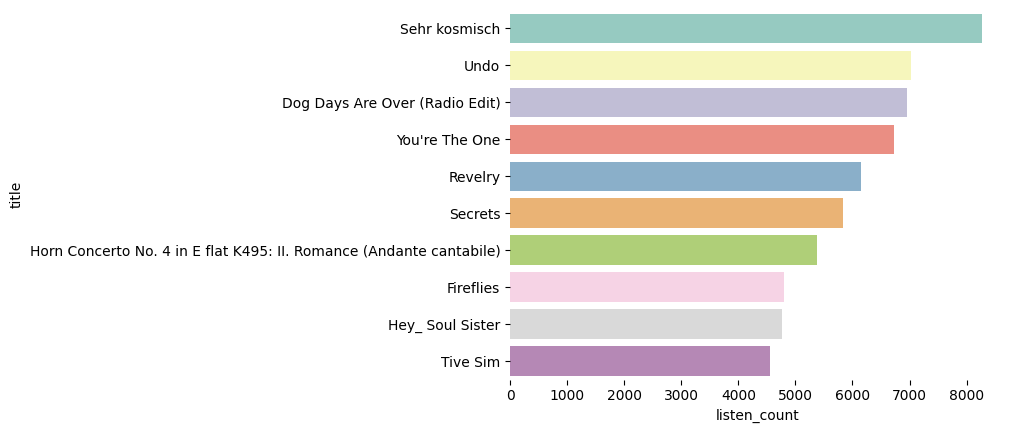

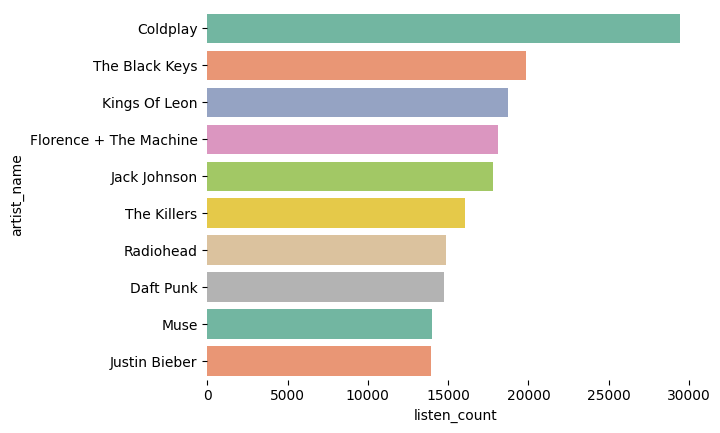

In [9]:
# Most popular songs and artists
ten_pop_songs = df_songs.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending=[0, 1])[:10]
ten_pop_artists = df_songs.groupby('artist_name')['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], ascending=[0, 1])[:10]

# Plotting
plt.figure()
sns.barplot(x=ten_pop_songs['listen_count'], y=ten_pop_songs['title'], palette='Set3')
sns.despine(left=True, bottom=True)

plt.figure()
sns.barplot(x=ten_pop_artists['listen_count'], y=ten_pop_artists['artist_name'], palette='Set2')
sns.despine(left=True, bottom=True)


Listen Count Distribution

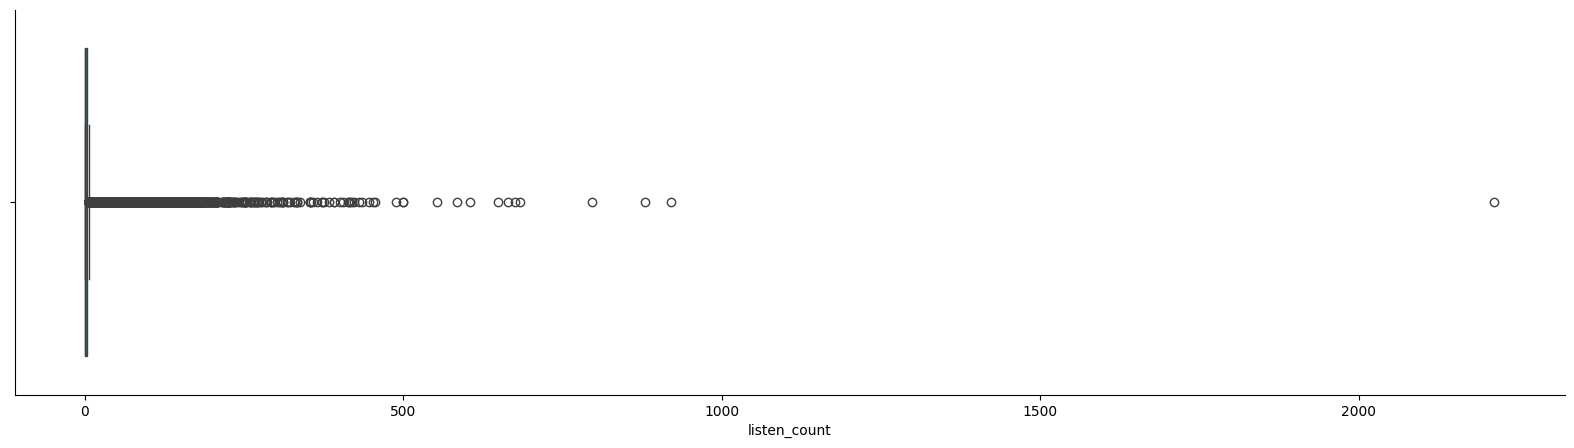

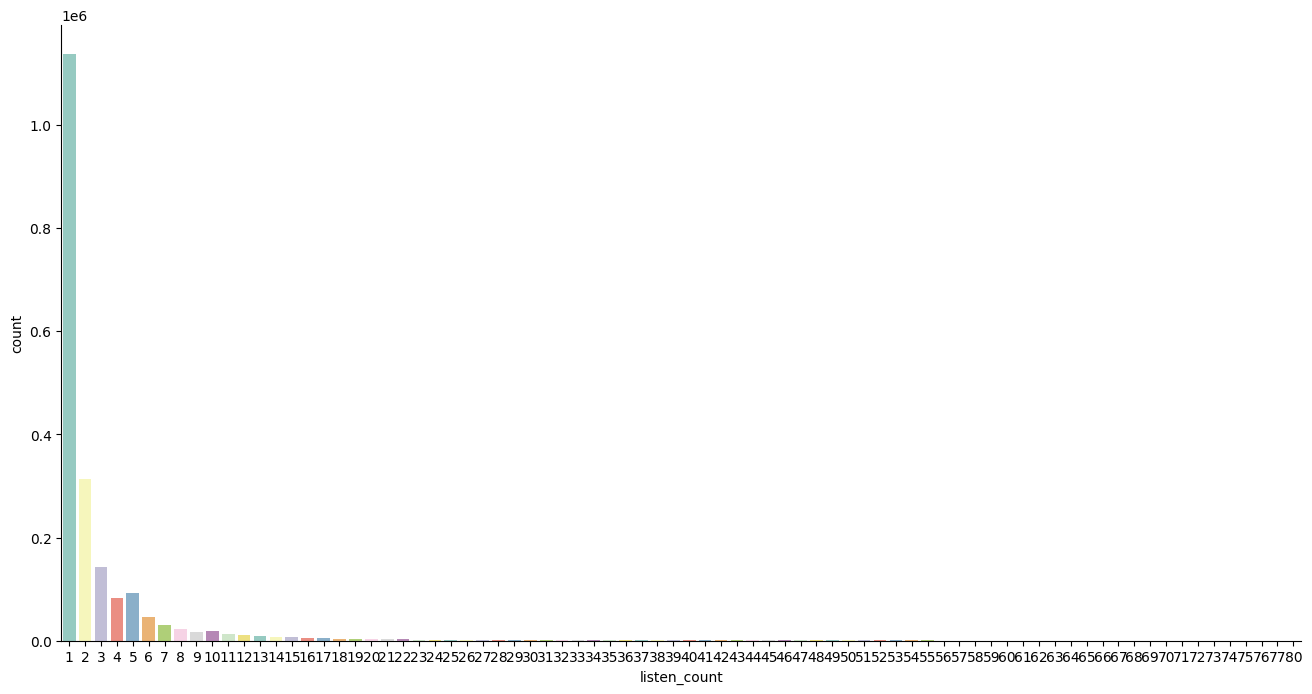

In [10]:
# Distribution of listen counts
listen_counts = pd.DataFrame(df_songs.groupby('listen_count').size(), columns=['count'])
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=df_songs)
sns.despine()

plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts[listen_counts['count'] > 50].reset_index(drop=False))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


4. Prepare Data for Recommendation
User-Song Matrix

In [11]:
import pandas as pd
from scipy.sparse import coo_matrix

# Convert IDs to numeric values
df_songs['user_id'] = pd.Categorical(df_songs['user_id']).codes
df_songs['song_id'] = pd.Categorical(df_songs['song_id']).codes

# Prepare user-song matrix
user_song_data = df_songs[['user_id', 'song_id', 'listen_count']].values
user_song_matrix = coo_matrix((user_song_data[:, 2], (user_song_data[:, 0], user_song_data[:, 1])))

# Convert to CSR format for faster operations
user_song_matrix_csr = user_song_matrix.tocsr()


Content-Based Recommender (Feature-Based)

In [12]:
class ContentBasedRecommender:
    def __init__(self, data, decode_id_song):
        self.data = data
        self.decode_id_song = decode_id_song
        self.model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
        self.model.fit(data)
    
    def recommend_songs(self, new_song, n_recommendations=5):
        recom_song_id = self._fuzzy_matching(new_song)
        if recom_song_id is None:
            return []
        distances, indices = self.model.kneighbors(self.data[recom_song_id].reshape(1, -1), n_neighbors=n_recommendations+1)
        recommendations_map = self._map_indices_to_song_title()
        return [recommendations_map[idx] for idx in indices.squeeze().tolist()[1:]]

    def _fuzzy_matching(self, song):
        match_tuple = [(title, idx, fuzz.ratio(title.lower(), song.lower())) for title, idx in self.decode_id_song.items()]
        match_tuple = sorted(match_tuple, key=lambda x: x[2], reverse=True)
        return match_tuple[0][1] if match_tuple and match_tuple[0][2] >= 60 else None
    
    def _map_indices_to_song_title(self):
        return {idx: title for title, idx in self.decode_id_song.items()}

# Example usage for content-based recommender
decode_id_song = {song: idx for idx, song in enumerate(df_songs['title'].unique())}
content_recommender = ContentBasedRecommender(data=user_song_matrix_csr, decode_id_song=decode_id_song)


Collaborative Filtering Recommender

User-Based and Item-Based Collaborative Filtering:

In [13]:
class CollaborativeFilteringRecommender:
    def __init__(self, data, decode_id_song, metric='cosine', algorithm='brute', k=20):
        self.metric = metric
        self.algorithm = algorithm
        self.k = k
        self.data = data
        self.decode_id_song = decode_id_song
        self.model = NearestNeighbors(metric=self.metric, algorithm=self.algorithm, n_neighbors=self.k, n_jobs=-1)
        self.model.fit(data)
    
    def recommend_songs(self, new_song, n_recommendations):
        recommended = self._recommend(new_song=new_song, n_recommendations=n_recommendations)
        return recommended 
    
    def _recommend(self, new_song, n_recommendations):
        recommendations = []
        recommendation_ids = self._get_recommendations(new_song=new_song, n_recommendations=n_recommendations)
        recommendations_map = self._map_indices_to_song_title()
        for i, (idx, dist) in enumerate(recommendation_ids):
            if idx in recommendations_map:
                recommendations.append(recommendations_map[idx])
        return recommendations
                 
    def _get_recommendations(self, new_song, n_recommendations):
        recom_song_id = self._fuzzy_matching(song=new_song)
        distances, indices = self.model.kneighbors(self.data[recom_song_id].reshape(1, -1), n_neighbors=n_recommendations+1)
        return sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    def _map_indices_to_song_title(self):
        return {idx: title for title, idx in self.decode_id_song.items()}
    
    def _fuzzy_matching(self, song):
        match_tuple = [(title, idx, fuzz.ratio(title.lower(), song.lower())) for title, idx in self.decode_id_song.items()]
        match_tuple = sorted(match_tuple, key=lambda x: x[2], reverse=True)
        return match_tuple[0][1] if match_tuple and match_tuple[0][2] >= 60 else None

# Example usage for collaborative filtering recommender
collab_recommender = CollaborativeFilteringRecommender(data=user_song_matrix_csr, decode_id_song=decode_id_song)


Save Models

In [14]:
# Save the models
with open('content_recommender.pkl', 'wb') as f:
    pickle.dump(content_recommender, f)

with open('collab_recommender.pkl', 'wb') as f:
    pickle.dump(collab_recommender, f)


**Integrate Both Approaches**


Define Helper Functions for Spotify Integration:

In [15]:
def get_spotify_tracks(track_names):
    client_credentials_manager = SpotifyClientCredentials(client_id='your_client_id', client_secret='your_client_secret')
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    track_uris = []
    for track in track_names:
        results = sp.search(q=f"track:{track}", limit=1)
        if results['tracks']['items']:
            track_data = results['tracks']['items'][0]
            track_uris.append(track_data)
    return track_uris

def print_tracks_table(track_uris):
    track_data = []
    for track in track_uris:
        track_data.append([
            track['name'],
            track['artists'][0]['name'],
            track['album']['name'],
            track['external_urls']['spotify']
        ])
    if track_data:
        print(tabulate(track_data, headers=["Track Name", "Artist", "Album", "Spotify URL"], tablefmt="grid"))
    else:
        print("No track data available to display.")


Example Usage:

In [16]:
# Load models
with open('content_recommender.pkl', 'rb') as f:
    content_recommender = pickle.load(f)

with open('collab_recommender.pkl', 'rb') as f:
    collab_recommender = pickle.load(f)

# Generate recommendations
new_song = 'The Fame Monster'
content_recommendations = content_recommender.recommend_songs(new_song=new_song, n_recommendations=5)
collab_recommendations = collab_recommender.recommend_songs(new_song=new_song, n_recommendations=5)

# Fetch Spotify details
track_uris_content = get_spotify_tracks(content_recommendations)
track_uris_collab = get_spotify_tracks(collab_recommendations)

# Print results
print("Content-Based Recommendations:")
print_tracks_table(track_uris_content)

print("Collaborative Filtering Recommendations:")
print_tracks_table(track_uris_collab)


KeyError: 56607